# Non-Covalent Interaction Index

The non-covalent interaction (NCI) method uses the isosurface of reduced density gradient defined as $$ s(\mathbf{r}) = \frac{1}{2(3\pi^2)^{1/3}} \frac{|\nabla \rho(\mathbf{r}) |}{\rho(\mathbf{r})^{4/3}}$$ 

for identifying non-covalent interactions.   This example will illustrate how to use cuGBasis to find such isosurfaces for the dipeptide example.

## Constructing Molecule Object

The first-step is to read the wave-function file and constructing the Molecule class.

In [1]:
from cugbasis import Molecule

file_path = r"./silica_water_cluster_uwb97xd_def2svpd.fchk"
mol = Molecule(file_path)

## Reduced Density Gradient Isosurface 

Here, we will calculate the reduced density gradient using cuGBasis and generate the isosurface from it.

In [2]:
import numpy as np
from skimage.measure import marching_cubes
from grid.cubic import UniformGrid
import matplotlib.pyplot as plt

# Construct another uniform grid but without a large extension
grid = UniformGrid.from_molecule(mol.atnums, mol.atcoords, spacing=0.03, extension=0.0)

# Calculate the reduced density gradient
rdg = mol.compute_reduced_density_gradient(grid.points)
# Remove points whose density cutoff is greater than 0.05
rdg[mol.compute_density(grid.points) > 0.08] = np.inf
# Reshape to match
rdg = rdg.reshape(grid.shape) 

# Find the isosurface of 0.3 a.u.
kverts, kfaces, _, _ = marching_cubes(rdg, 0.3, allow_degenerate=False)
kverts = kverts.dot(grid.axes) + grid.origin
print(f"Number of vertices: {len(kverts)}")

# Compute the density again on the isosurface to validate it
rdg_iso = mol.compute_reduced_density_gradient(kverts)
print(f"Mean Density on isosurface: {np.mean(rdg_iso)}")
print(f"STD  Density on isosurface: {np.std(rdg_iso)}")

Number of vertices: 14848
Mean Density on isosurface: 0.29972415519467555
STD  Density on isosurface: 0.0003595601354437498


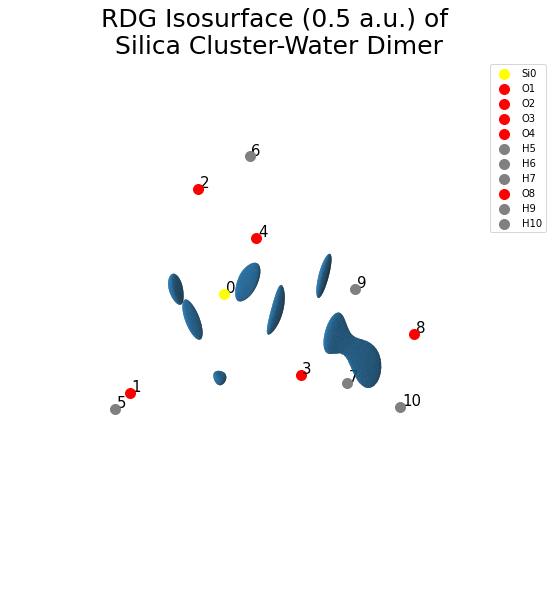

In [3]:
%matplotlib inline

atom_colors = {14: "yellow", 8: "red", 1: "grey", 6: "carbon"}
atom_type = {14: "Si", 8: "O", 6: "C", 1: "H"}

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")
ax.plot_trisurf(kverts[:, 0], kverts[:, 1], kverts[:, 2], triangles=kfaces)
for i, (coord, numb) in enumerate(zip(mol.atcoords, mol.atnums)):
    ax.scatter(coord[0], coord[1], coord[2], color=atom_colors[numb], s=100, label=atom_type[numb] + f"{i}")
    ax.text(coord[0]+ 0.03, coord[1]+ 0.03, coord[2] + 0.03, i, fontsize=15)
plt.axis("off")
plt.title("RDG Isosurface (0.5 a.u.) of \n Silica Cluster-Water Dimer ", fontsize=25)
plt.legend()
plt.show()

## NCI Index Using The Hessian 

The sign of the second eigenvalue of the Hessian with the product of its electron density, i.e. $sign(\lambda_2) \rho(\mathbf{r})$, can be used to further classify non-covalent interactions. The sign of the eigenvalues measures how much charge is accumulation in the perpendicular plane of the interaction.  If it is negative, it is an indication of strongly attractive NCI (hydrogen bonds). If it is close to zero, it is a sign of van der Waals interactions and if it is positive it is an example of steric clashes. Following the previous example, here we will see that there is a strongly non-covalent interaction between water molecule and silica cluster.

In [4]:
%matplotlib inline 

# Compute the hessian
hessian = mol.compute_hessian(kverts)
print(f"Shape of the Hessian: {hessian.shape}.")

# Compute the eigenvalues of the Hessian at each point.
eigs = np.linalg.eigvalsh(hessian)
print(f"Shape of the eigenvalues: {eigs.shape}")

# Get the second eigenvalue of each point and compute the classification
eigs = np.sort(eigs, axis=1)[:, 1]
sign_hess = np.sign(eigs) * mol.compute_density(kverts)

Shape of the Hessian: (14848, 3, 3).
Shape of the eigenvalues: (14848, 3)


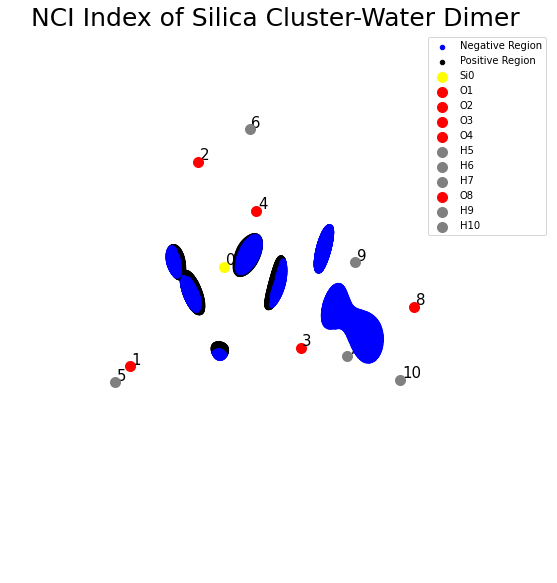

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")
neg = sign_hess < 0.02
ax.scatter(kverts[neg, 0], kverts[neg, 1], kverts[neg, 2], color="b", label="Negative Region")
pos = sign_hess > 0.02
ax.scatter(kverts[pos, 0], kverts[pos, 1], kverts[pos, 2], color="k", label="Positive Region")
for i, (coord, numb) in enumerate(zip(mol.atcoords, mol.atnums)):
    ax.scatter(coord[0], coord[1], coord[2], color=atom_colors[numb], s=100, label=atom_type[numb] + f"{i}")
    ax.text(coord[0]+ 0.03, coord[1]+ 0.03, coord[2] + 0.03, i, fontsize=15)
plt.axis("off")
plt.legend()
plt.title("NCI Index of Silica Cluster-Water Dimer ", fontsize=25)
plt.show()